In [1]:
import os
import pandas as pd
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models # 이미지
from torchvision import transforms
from PIL import Image
from transformers import GPT2Tokenizer, GPT2Model # 텍스트
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split

In [2]:
########## Dataset ##########

class VQADataset(Dataset):
    def __init__(self, df, tokenizer, transform, img_path, is_test=False):
        self.df = df
        self.tokenizer = tokenizer
        self.transform = transform
        self.img_path = img_path
        self.is_test = is_test

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        img_name = os.path.join(self.img_path, row['image_id'] + '.jpg') # 이미지
        image = Image.open(img_name).convert('RGB')
        image = self.transform(image)

        question = row['question'] # 질문
        question = self.tokenizer.encode_plus(
            question,
            truncation=True,
            add_special_tokens=True,
            max_length=32,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )

        if not self.is_test:
            answer = row['answer'] # 답변
            answer = self.tokenizer.encode_plus(
                answer,
                max_length=32,
                padding='max_length',
                truncation=True,
                return_tensors='pt')
            return {
                'image': image.squeeze(),
                'question': question['input_ids'].squeeze(),
                'answer': answer['input_ids'].squeeze()
            }
        else:
            return {
                'image': image,
                'question': question['input_ids'].squeeze(),
            }

In [3]:
import torch
from torch import nn
from torchvision import models

class VQAModel(nn.Module):
    def __init__(self, vocab_size):
        super(VQAModel, self).__init__()
        self.vocab_size = vocab_size

        # Inception v3 모델 로드, 최종 레이어를 Identity로 설정
        self.inception = models.inception_v3(pretrained=True)
        self.inception.fc = nn.Identity()  # 분류기 부분 제거

        # GPT-2 모델 로드
        from transformers import GPT2Model
        self.gpt2 = GPT2Model.from_pretrained('gpt2')
        self.gpt2.resize_token_embeddings(vocab_size)

        # Inception v3 출력 차원 (2048)과 GPT-2 출력 차원 합산
        combined_features_size = 2048 + self.gpt2.config.hidden_size
        self.classifier = nn.Linear(combined_features_size, vocab_size)

    def forward(self, images, question):
    # Inception 모델 호출
        outputs = self.inception(images)
        
        # logits 속성을 사용하여 이미지 특성을 가져옵니다.
        image_features = outputs if isinstance(outputs, torch.Tensor) else outputs.logits
    
        # 이미지 특성의 차원 조정
        image_features = image_features.view(image_features.size(0), -1)
    
        # GPT-2 모델을 통한 텍스트 특성 처리
        text_outputs = self.gpt2(question)
        output_features = text_outputs.last_hidden_state
    
        # 이미지와 텍스트 특성 결합
        image_features = image_features.unsqueeze(1).expand(-1, output_features.size(1), -1)
        combined = torch.cat([image_features, output_features], dim=-1)
    
        # 최종 출력 계산
        output = self.classifier(combined)
    
        return output



In [4]:
### Accuracy ###
def calculate_accuracy(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            images = data['image'].to(device)
            question = data['question'].to(device)
            labels = data['answer'].to(device)
            outputs = model(images, question)
            _, predicted = torch.max(outputs, dim=2)
            total += labels.size(0) * labels.size(1)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

In [5]:
### Tran & Inference ###
def train(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for data in tqdm(loader, total=len(loader)):
        images = data['image'].to(device)
        question = data['question'].to(device)
        answer = data['answer'].to(device)
        optimizer.zero_grad()
        outputs = model(images, question)
        loss = criterion(outputs.view(-1, outputs.size(-1)), answer.view(-1))
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    avg_loss = total_loss / len(loader)
    return avg_loss

def inference(model, loader):
    model.eval()
    preds = []
    with torch.no_grad():
        for data in tqdm(loader, total=len(loader)):
            images = data['image'].to(device)
            question = data['question'].to(device)
            outputs = model(images, question)
            _, pred = torch.max(outputs, dim=2)
            preds.extend(pred.cpu().numpy())
    return preds

In [6]:
#from google.colab import drive
#drive.mount('/content/drive')

In [7]:
### 데이터 로드 ###
#df = pd.read_csv('filtered_train.csv')
df = pd.read_csv('./color_questions.csv')

# train 및 test 분할
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)

# temp_df를 다시 test_df와 val_df로 분할
test_df, val_df = train_test_split(temp_df, test_size=0.5, random_state=42)

#train_img_path = '/content/drive/MyDrive/image'
train_img_path = './image/train3/train3'

### Load ###
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.add_special_tokens({'pad_token': '[PAD]'})
vocab_size = len(tokenizer)

transform = transforms.Compose([
    transforms.Resize((299, 299)),  # 이미지 크기를 Inception v3에 적합하게 조정
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = VQADataset(train_df, tokenizer, transform, train_img_path, is_test=False)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataset = VQADataset(val_df, tokenizer, transform, train_img_path, is_test=False)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [8]:

### Run ###
# device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"current device is {device}")

# Model
model = VQAModel(vocab_size).to(device)

## gpu 2개 쓸 수있도록
model = nn.DataParallel(model)

# Criterion and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=5e-5)

current device is cuda


/home/cvlserver/anaconda3/envs/haewon_horse/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/cvlserver/anaconda3/envs/haewon_horse/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
### Training loop ###
for epoch in range(10):
    avg_loss = train(model, train_loader, optimizer, criterion)
    val_accuracy = calculate_accuracy(model, val_loader)
    print(f"Epoch: {epoch+1}, Loss: {avg_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

  0%|          | 0/493 [00:00<?, ?it/s]

Epoch: 1, Loss: 0.4165, Val Accuracy: 96.90%


  0%|          | 0/493 [00:00<?, ?it/s]

Epoch: 2, Loss: 0.1148, Val Accuracy: 97.34%


  0%|          | 0/493 [00:00<?, ?it/s]

Epoch: 3, Loss: 0.0987, Val Accuracy: 97.36%


  0%|          | 0/493 [00:00<?, ?it/s]

Epoch: 4, Loss: 0.0855, Val Accuracy: 97.38%


  0%|          | 0/493 [00:00<?, ?it/s]

Epoch: 5, Loss: 0.0746, Val Accuracy: 97.29%


  0%|          | 0/493 [00:00<?, ?it/s]

Epoch: 6, Loss: 0.0646, Val Accuracy: 97.34%


  0%|          | 0/493 [00:00<?, ?it/s]

Epoch: 7, Loss: 0.0550, Val Accuracy: 97.26%


  0%|          | 0/493 [00:00<?, ?it/s]

Epoch: 8, Loss: 0.0473, Val Accuracy: 97.24%


  0%|          | 0/493 [00:00<?, ?it/s]

Epoch: 9, Loss: 0.0417, Val Accuracy: 97.27%


  0%|          | 0/493 [00:00<?, ?it/s]

Epoch: 10, Loss: 0.0378, Val Accuracy: 97.18%


In [10]:
########## model save ##########
torch.save(model, './saved_pth/horse_Inception2.pth')

In [11]:
test_dataset = VQADataset(test_df, tokenizer, transform, train_img_path, is_test=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

test_accuracy = calculate_accuracy(model, test_loader)
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 97.16%


In [12]:
########## 이미지 전처리 함수 ##########

def transform_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = Image.open(image_path).convert('RGB')
    return transform(image).unsqueeze(0)  # 차원 추가: [C, H, W] -> [1, C, H, W]

########## 질문 전처리 후 답변 생성 ##########

def generate_answer(model, image_path, question):
    # 이미지 전처리
    image_tensor = transform_image(image_path).to(device)

    # 질문 전처리
    tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})
    question_encoding = tokenizer.encode_plus(
        question, return_tensors='pt', truncation=True,
        add_special_tokens=True, max_length=32, padding='max_length'
    )
    question_tensor = question_encoding['input_ids'].to(device)

    # 모델을 사용하여 답변 생성
    with torch.no_grad():
        outputs = model(image_tensor, question_tensor)
        pred_ids = torch.argmax(outputs, dim=2)  # 예측된 토큰 ID
        answer_tokens = pred_ids[0, :].tolist()  # 첫 번째 출력(배치 크기 1)에서 토큰 추출
        answer = tokenizer.decode(answer_tokens, skip_special_tokens=True)

    return answer

In [13]:
image_path = "./self_test_image.jpg"
question = input("Enter your question: ")

# 답변 생성
answer = generate_answer(model, image_path, question)
print("Answer:", answer)

Enter your question:  What is the color of the clothes that people wear?


Answer: blue


Enter your question:  What is the color of the clothes that people wear?


Answer: blue


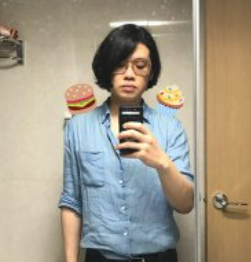

In [14]:
from IPython.display import display

image_path = "./self_test_image5.png"
question = input("Enter your question: ")

# 답변 생성
answer = generate_answer(model, image_path, question)
print("Answer:", answer)
image = Image.open(image_path)
display(image)